In [1]:
from deepcrypto.backtest import *
from deepcrypto.portfolio_analysis import *
from deepcrypto.data_utils.crawlers.bitfinex_kaggle import *
from talib.abstract import *
from pprint import pprint

In [19]:
def strategy(df, config):
    volume = df.volume
    close = df.close
    
    volume_std = volume.rolling(config["volume_p"]).std()
    volume_mean = volume.rolling(config["volume_p"]).mean()
    
    close_std = close.rolling(config["price_p"]).std()
    close_mean = close.rolling(config["price_p"]).mean()
    
    volume_signal = volume > (volume_mean + volume_std * config["volume_std_coef"])
    price_signal = close > (close_mean + close_std * config["price_std_coef"])
    
    # volume_signal = (volume_signal & (volume_signal.diff() == 1))
    # price_signal = (price_signal & (price_signal.diff() == 1))
        
    df["enter_long"] = volume_signal & price_signal
    df["enter_long"] = df["enter_long"] & (df["enter_long"].diff() == 1)
    df["trade_cost"] = 0.001
    df["bet"] = np.clip(0.01 / df.close.pct_change().rolling(200).std(), 0.1, 2) * 2
    df["stop_loss"] = config["stop_loss"]
    df["take_profit"] = config["take_profit"]
    df["time_cut"] = config["time_cut"]
    return df

In [3]:
def backtest_and_report(config, ticker):
    data = read_bitfinex_data("/home/ych/Storage/bitfinex/bitfinex.db", "1H", ticker)
    data = data.backtest.add_defaults()

    order, port = strategy(data, config).backtest()
    pprint(calc_from_order_df(order))
    qs.reports.full(port["portfolio_value"].resample("1D").last(), benchmark=port["open"].resample("1D").last())

In [23]:
DEFAULT_CONFIG = {'time_cut': 24,
 'stop_loss': 0.03,
 'take_profit': 0.2,
 'volume_p': 48,
 'price_p': 24,
 'volume_std_coef': 2.5,
 'price_std_coef': 2}

backtest completed in 0.055529117584228516 seconds
{'bothside_avg_holding_bars': 18.28391167192429,
 'bothside_profit_factor': 1.802049212931903,
 'bothside_total_profit': 26351387.722195532,
 'bothside_total_trades': 317,
 'bothside_win_rate': 50.1577287066246,
 'buyside_avg_holding_bars': 18.28391167192429,
 'buyside_profit_factor': 1.802049212931903,
 'buyside_total_profit': 26351387.722195532,
 'buyside_total_trades': 317,
 'buyside_win_rate': 50.1577287066246,
 'sellside_avg_holding_bars': nan,
 'sellside_profit_factor': nan,
 'sellside_total_profit': 0.0,
 'sellside_total_trades': 0,
 'sellside_win_rate': nan}


/home/ych/PycharmProjects/DeepCrypto/deepcrypto/portfolio_analysis/__init__.py:7: RuntimeWarning: invalid value encountered in long_scalars
  a[f"{label}_win_rate"] = order_df.realized[order_df.realized >= 0].count()/order_df.realized.count() * 100


                           Strategy     Benchmark
-------------------------  -----------  -----------
Start Period               2016-03-18   2016-03-18
End Period                 2021-05-18   2021-05-18
Risk-Free Rate             0.0%         0.0%
Time in Market             29.0%        97.0%

Cumulative Return          211,594.41%  31,191.55%
CAGR%                      339.83%      203.87%

Sharpe                     1.72         1.31
Sortino                    3.97         2.07
Sortino/√2                 2.81         1.46

Max Drawdown               -48.66%      -93.85%
Longest DD Days            161          1101
Volatility (ann.)          74.17%       87.76%
R^2                        0.17         0.17
Calmar                     6.98         2.17
Skew                       3.67         0.38
Kurtosis                   24.94        5.56

Expected Daily %           0.41%        0.3%
Expected Monthly %         12.92%       9.55%
Expected Yearly %          258.33%      160.56%
Kelly Cr

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2019-10-10,2020-01-12,2020-03-19,161,-48.661160,-47.337006
2,2019-01-05,2019-02-03,2019-02-18,44,-38.387231,-30.963108
3,2020-05-31,2020-06-11,2020-08-01,62,-37.284282,-34.755053
4,2019-04-14,2019-06-11,2019-06-23,70,-30.710705,-30.269155
5,2020-09-02,2020-10-20,2020-11-06,65,-30.438951,-28.596325


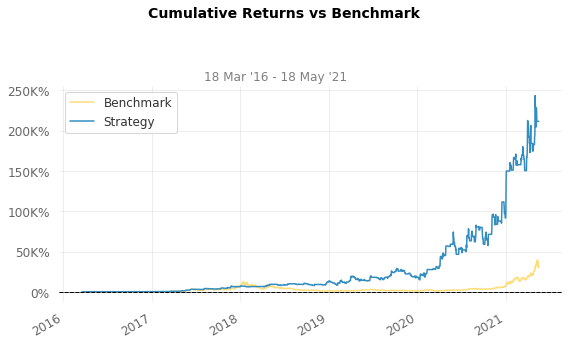

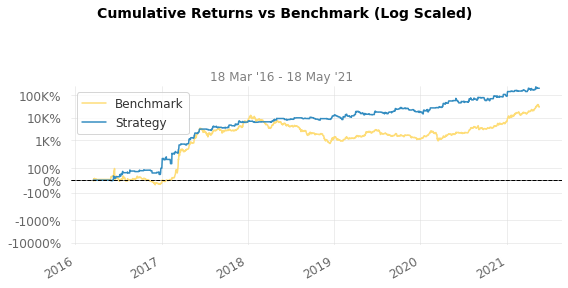

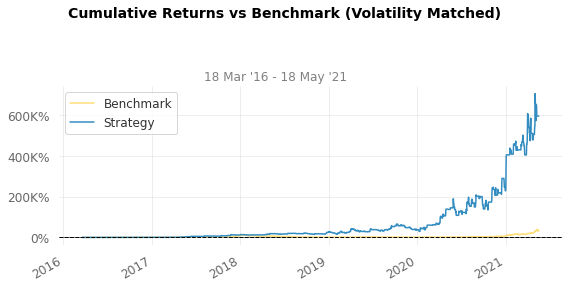

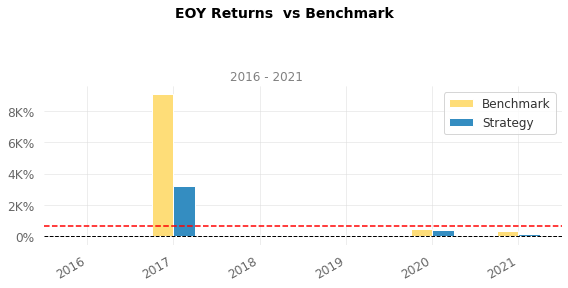

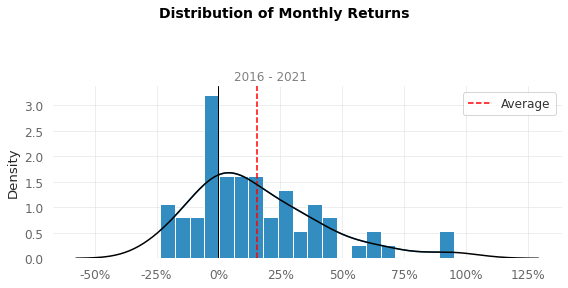

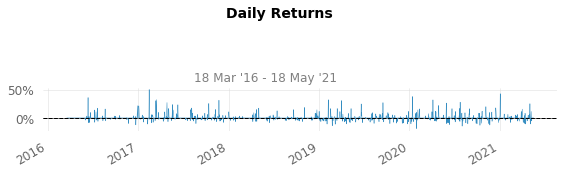

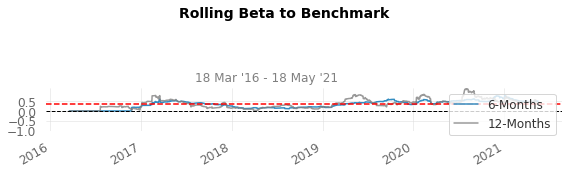

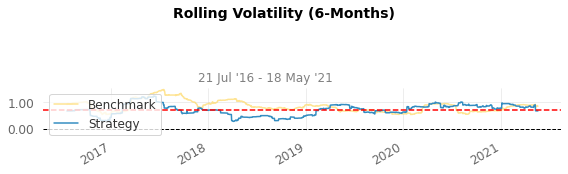

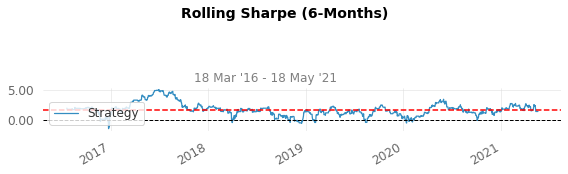

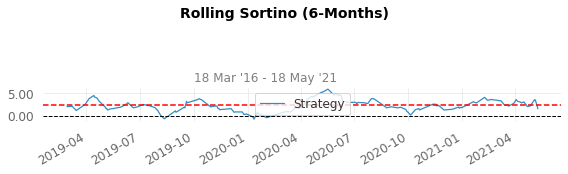

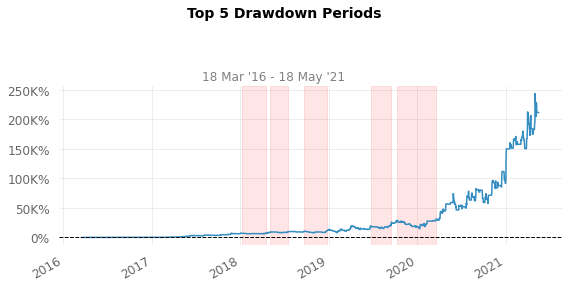

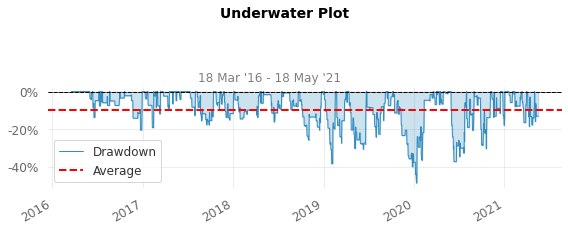

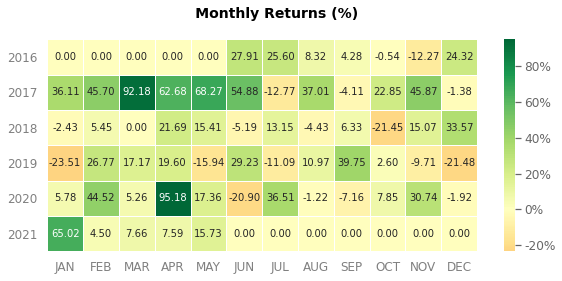

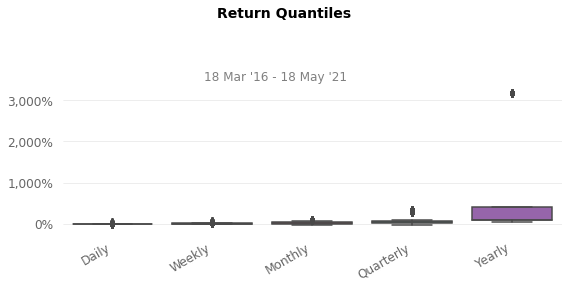

In [24]:
backtest_and_report(DEFAULT_CONFIG, "ETHUSD")

backtest completed in 0.08905601501464844 seconds
{'bothside_avg_holding_bars': 18.448351648351647,
 'bothside_profit_factor': 1.568879550915132,
 'bothside_total_profit': 1007620918.559708,
 'bothside_total_trades': 455,
 'bothside_win_rate': 55.16483516483517,
 'buyside_avg_holding_bars': 18.448351648351647,
 'buyside_profit_factor': 1.568879550915132,
 'buyside_total_profit': 1007620918.559708,
 'buyside_total_trades': 455,
 'buyside_win_rate': 55.16483516483517,
 'sellside_avg_holding_bars': nan,
 'sellside_profit_factor': nan,
 'sellside_total_profit': 0.0,
 'sellside_total_trades': 0,
 'sellside_win_rate': nan}


/home/ych/PycharmProjects/DeepCrypto/deepcrypto/portfolio_analysis/__init__.py:7: RuntimeWarning: invalid value encountered in long_scalars
  a[f"{label}_win_rate"] = order_df.realized[order_df.realized >= 0].count()/order_df.realized.count() * 100


                           Strategy       Benchmark
-------------------------  -------------  -----------
Start Period               2013-04-09     2013-04-09
End Period                 2021-05-18     2021-05-18
Risk-Free Rate             0.0%           0.0%
Time in Market             26.0%          96.0%

Cumulative Return          7,377,142.06%  18,597.53%
CAGR%                      298.16%        90.56%

Sharpe                     1.79           0.99
Sortino                    4.54           1.48
Sortino/√2                 3.21           1.04

Max Drawdown               -46.72%        -84.25%
Longest DD Days            213            1126
Volatility (ann.)          63.24%         69.36%
R^2                        0.14           0.14
Calmar                     6.38           1.07
Skew                       6.15           0.14
Kurtosis                   82.22          10.5

Expected Daily %           0.38%          0.18%
Expected Monthly %         12.12%         5.48%
Expected Yearly 

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-05-17,2020-10-08,2020-12-16,213,-46.723018,-44.876198
2,2018-12-21,2019-02-03,2019-05-11,141,-33.912098,-27.541551
3,2014-07-12,2014-09-24,2014-11-12,123,-31.176602,-30.380007
4,2015-07-06,2015-09-24,2015-10-30,116,-25.461887,-23.967009
5,2014-03-26,2014-05-17,2014-05-22,57,-25.264255,-24.750887


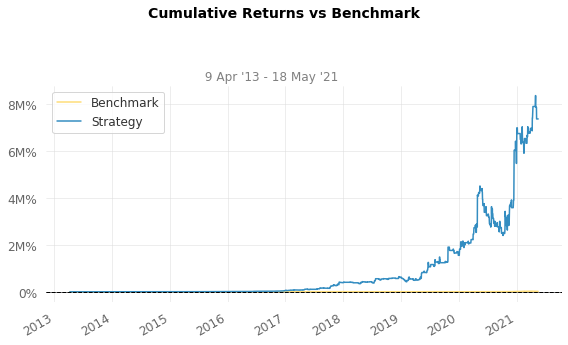

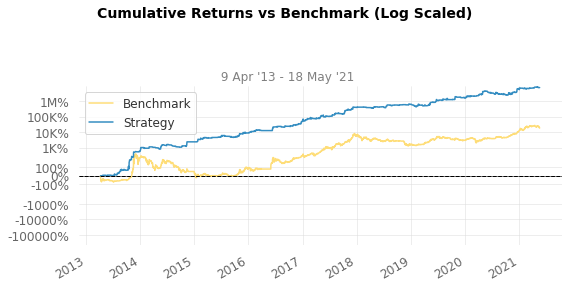

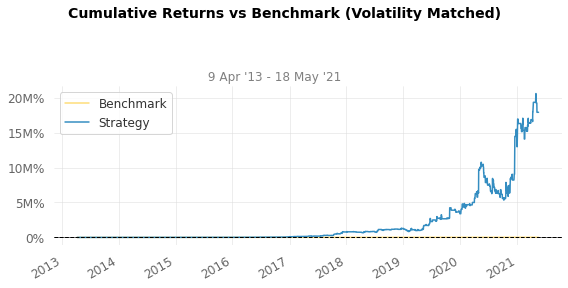

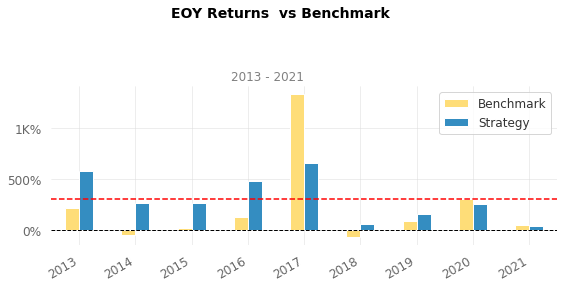

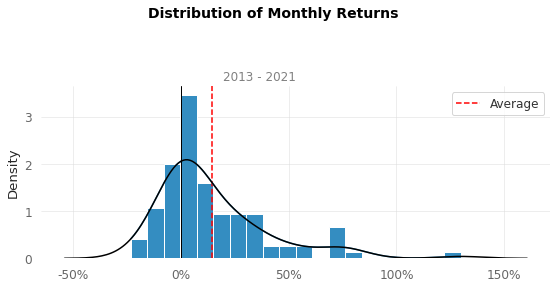

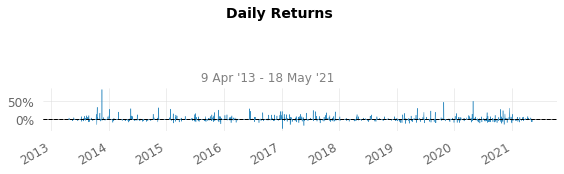

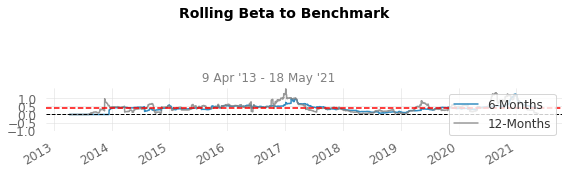

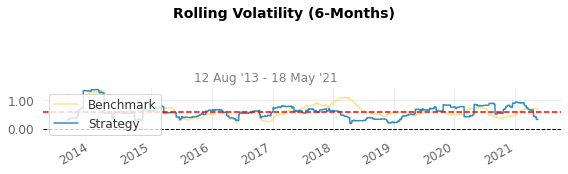

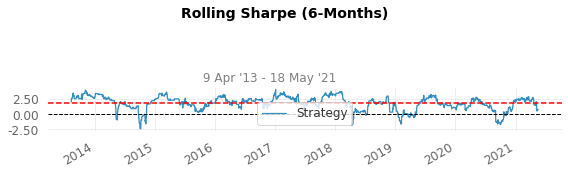

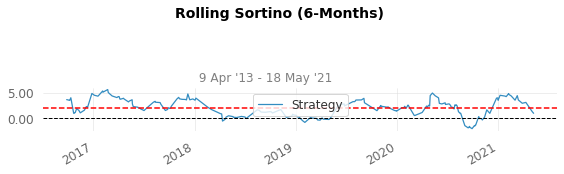

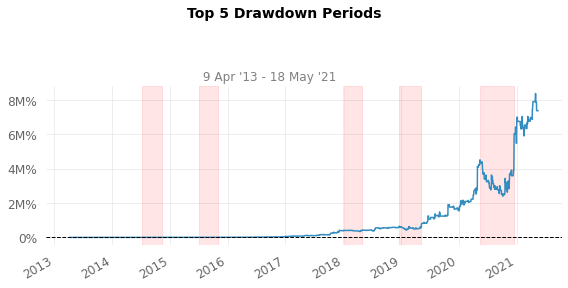

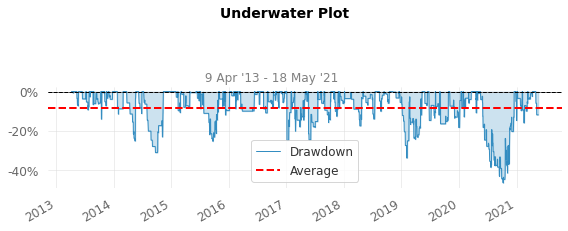

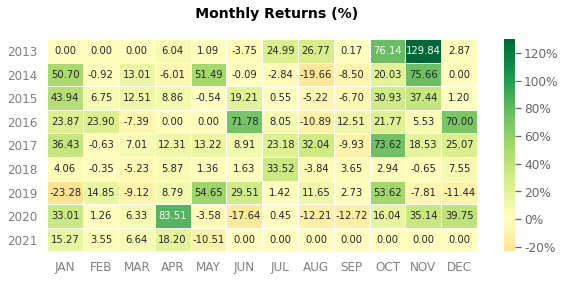

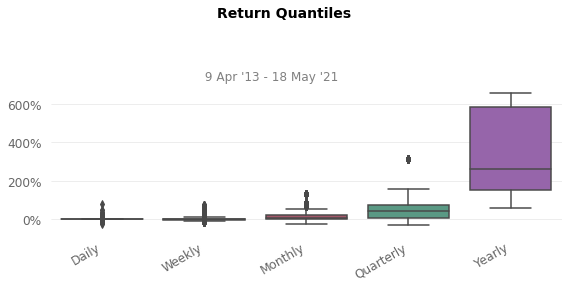

In [26]:
DEFAULT_CONFIG = {'time_cut': 24,
 'stop_loss': 0.02,
 'take_profit': 0.2,
 'volume_p': 48,
 'price_p': 96,
 'volume_std_coef': 2.5,
 'price_std_coef': 1.5}

backtest_and_report(DEFAULT_CONFIG, "BTCUSD")

In [7]:
import ray
from ray import tune
def optimizer(config, df):
    df = df.copy()
    order_df, port_df = run_backtest_df(strategy(df, config))
    tune.report(sortino=qs.stats.sortino(port_df["portfolio_value"].resample("1D").last()))

def optimize(df):
    result = tune.run(
        tune.with_parameters(optimizer, df=df),
        config = {
            "time_cut" : tune.grid_search([24, 48, 96]),
            "stop_loss" : tune.grid_search([0.02, 0.03, 0.05, 0.1]),
            "take_profit" : tune.grid_search([0.05, 0.1, 0.15, 0.2]),
            'volume_p' : tune.grid_search([24, 48, 96]),
            'price_p' : tune.grid_search([24, 48, 96]),
            'volume_std_coef' : tune.grid_search([1.5, 2, 2.5, 3]),
            'price_std_coef' : tune.grid_search([1.5, 2, 2.5, 3])
        },
        local_dir="./ray_results",
    )
    return result

/home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  "update your install command.", FutureWarning)


In [8]:
ray.init()

2021-05-27 10:01:31,854	INFO services.py:1269 -- View the Ray dashboard at http://127.0.0.1:8266


{'node_ip_address': '192.168.68.106',
 'raylet_ip_address': '192.168.68.106',
 'redis_address': '192.168.68.106:25007',
 'object_store_address': '/tmp/ray/session_2021-05-27_10-01-30_741550_209257/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-05-27_10-01-30_741550_209257/sockets/raylet',
 'webui_url': '127.0.0.1:8266',
 'session_dir': '/tmp/ray/session_2021-05-27_10-01-30_741550_209257',
 'metrics_export_port': 50569,
 'node_id': 'd2dde94db0c7988f07b01c9ea484718b43e8e825a02b7b7fb1b25053'}

In [9]:
data = read_bitfinex_data("/home/ych/Storage/bitfinex/bitfinex.db", "1H", "ETHUSD")
data = data.backtest.add_defaults()

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


In [10]:
data = data[:int(data.index.__len__() * 0.7)]

In [ ]:
result = optimize(data)

In [12]:
result.get_best_config("sortino", mode="max")

{'time_cut': 24,
 'stop_loss': 0.03,
 'take_profit': 0.2,
 'volume_p': 48,
 'price_p': 24,
 'volume_std_coef': 2.5,
 'price_std_coef': 2}